In [ ]:
# Importing Googe Drive
from google.colab import drive
import sys, os
import numpy as np
import pandas as pd
drive.mount('/content/drive/')

sys.path.append('/content/drive/Shareddrives/CFA project/utils')

Mounted at /content/drive/


In [ ]:
# Importing necessary packages and libraries
# Niu: added the first line to update openpyxl, which is necessary for pandas to read databases

!pip install openpyxl --upgrade

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import statsmodels.api as sm
from functools import reduce

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Pre-Processing

In [ ]:
!pip install category_encoders

     |████████████████████████████████| 86 kB 4.0 MB/s 


In [ ]:
from category_encoders.target_encoder import TargetEncoder
from category_encoders.sum_coding import SumEncoder
from category_encoders.m_estimate import MEstimateEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.binary import BinaryEncoder
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.james_stein import JamesSteinEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_pickle('/content/drive/Shareddrives/CFA project/data/loaded_df.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20020 entries, 14824 to 20019
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Stock                            20020 non-null  object 
 1   Free.Operating.Cash.Flow         20019 non-null  float64
 2   Total.Debt.Outstanding           20020 non-null  float64
 3   Price.Close                      20020 non-null  float64
 4   Total.Common.Shares.Outstanding  20020 non-null  int64  
 5   Cash.and.Equivalents             20020 non-null  int64  
 6   Net.Income                       20020 non-null  int64  
 7   Interest.Expense                 19415 non-null  float64
 8   Short.Interest                   20020 non-null  float64
 9   Avg.Daily.Volume.30D             20020 non-null  int64  
 10  Current.Assets                   20020 non-null  float64
 11  Non.Current.Assets               20020 non-null  float64
 12  Current.Liabil

In [ ]:
df = df.dropna(subset=['age','sector','industry']).reset_index(drop=True)

In [ ]:
df = df.sort_values(by=['DATE'])
df[['Free.Operating.Cash.Flow', 'Interest.Expense']] = df.groupby('Stock')[['Free.Operating.Cash.Flow', 'Interest.Expense']].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))

In [ ]:
df.isna().sum()
# 9143571303

Stock                              0
Free.Operating.Cash.Flow           0
Total.Debt.Outstanding             0
Price.Close                        0
Total.Common.Shares.Outstanding    0
Cash.and.Equivalents               0
Net.Income                         0
Interest.Expense                   0
Short.Interest                     0
Avg.Daily.Volume.30D               0
Current.Assets                     0
Non.Current.Assets                 0
Current.Liabilities                0
RSI.Exponential                    0
MACD.Line1                         0
Bollinger.Band,Width               0
Price.Mo.Volatility.T12M           0
3M.Sharpe.Ratio                    0
DATE                               0
CPIAUCSL                           0
PAYEMS                             0
PPIACO                             0
T10YIE                             0
T5YIE                              0
UNRATE                             0
industry                           0
age                                0
M

In [ ]:
fundamentals = ['Free.Operating.Cash.Flow', 'Total.Debt.Outstanding',
       'Total.Common.Shares.Outstanding',
       'Cash.and.Equivalents', 'Net.Income', 'Interest.Expense',
       'Short.Interest', 'Avg.Daily.Volume.30D', 'Current.Assets',
       'Non.Current.Assets', 'Current.Liabilities']

technicals = ['RSI.Exponential','MACD.Line1', 'Bollinger.Band,Width', 'Price.Mo.Volatility.T12M']

macros_features = ['CPIAUCSL', 'PAYEMS', 'PPIACO', 'T10YIE', 'T5YIE','UNRATE']

In [ ]:
# keep two types of data: X: [attributes] -> y: close price
#                         X: [pct_change_attributes] -> y: pct_change in close price
#TODO: determine y: average? EWA? One single close may not show the whole level of increase/decrease
df = df.sort_values(by=['DATE'])
df_val = df.copy()
df_val['next_close'] = df_val.groupby(['Stock'])['Price.Close'].transform(lambda x: x.shift(-1))
df_diff = df.copy()

df_val_diff = df.copy()
df_val_diff['next_close'] = df_val_diff.groupby(['Stock'])['Price.Close'].transform(lambda x: x.diff(1).shift(-1))

features_as_diff = fundamentals + technicals + macros_features
df_val_diff[features_as_diff] = df_val_diff.groupby(['Stock'])[features_as_diff].transform(lambda x: x.diff(1))[features_as_diff]

# calculate pct_diff as y
df_diff['pct_change_close'] = df_diff.groupby(['Stock'])['Price.Close'].transform(lambda x: x.pct_change().shift(-1))

# fundamental, close price, and macro shall be saved as pct_change to reflect the pct_change in y; 
#TODO: shall technical indicators be counted as pct_change as well or remain as is?
features_as_pct = fundamentals + ['Price.Close'] + macros_features
df_diff[features_as_pct] = df_diff.groupby(['Stock'])[features_as_pct].transform(lambda x: x.pct_change())[features_as_pct]

In [ ]:
df_diff = df_diff.dropna().reset_index()
df_val = df_val.dropna().reset_index()
df_val_diff = df_val_diff.dropna().reset_index()

In [ ]:
df_diff = df_diff.replace(np.inf, 1)  
df_diff = df_diff.replace(-np.inf, -1)  

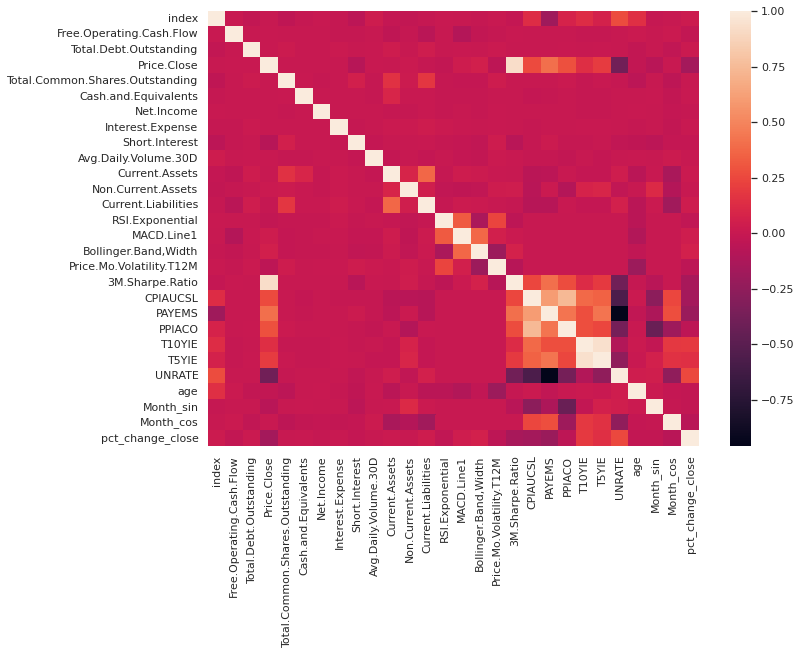

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize': (11,8)})
sns.heatmap(df_diff.corr())

In [ ]:
col_2_drop = ['T5YIE', 'Price.Close', 'PAYEMS', '3M.Sharpe.Ratio', 'industry', 'index']
df_diff = df_diff.drop(columns=col_2_drop)
df_val = df_val.drop(columns=col_2_drop)
df_val_diff = df_val_diff.drop(columns=col_2_drop)

In [ ]:
def prepare_data(data, drop_features, y_feature, test_size, test_idx, normalize_cols, clip_outliers_cols, clip_quantile = 0.99, encoding_method='BinaryEncoder',
                 train_test_split_type='random', normalize_method='RobustScaler',
                 encoding_col='sector', random_seed=40, **kwargs):
    """

  :param data:
  :param L: sequence length
  :param drop_features: features to drop
  :param y_feature:
  :param train_test_split_type: 'random': randomly split ; 'date': split by a quarter e.g., 2019Q4; 'idx': use given test idx as test set, else as train. Default random
  :param test_size: if train_test_slit == 'random': test/all, e.g. 0.3. else: the quarter string to split
  :param encoding_method: str() of encoder to use. Default binaryencoder
  :param encoding_col: col name to encode
  :param sigma: for LOO and catboost encoder -- gaussian noise added to the encoder
  :param random_seed: random_seed for train_test_split under the random mode.
  :return: tuple of X_train, X_test, y_train, y_test
  """

    df = data.copy()
    df = df.sort_values(by=['DATE']).reset_index(drop=True)
    for col in clip_outliers_cols:
      percentiles = df[col].quantile([1-clip_quantile, clip_quantile]).values
      df[col] = np.clip(df[col], percentiles[0], percentiles[1])
    X, y = df.drop(columns=[y_feature]), df[y_feature]

    # if split dataset randomly
    if train_test_split_type == 'random':

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                            random_state=random_seed)
    # if split dataset by a time (quarter)
    elif train_test_split_type == 'date':
        train, test = df[df['DATE'] <= test_size].sort_values(by=['DATE']), df[df['DATE'] > test_size].sort_values(
            by=['DATE'])
        X_train, X_test, y_train, y_test = train.drop(columns=[y_feature]), test.drop(columns=[y_feature]), train[y_feature] , test[y_feature]
    
    elif train_test_split_type == 'idx':
        train, test = pd.merge(df, test_idx, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1), pd.merge(df, test_idx)
        X_train, X_test, y_train, y_test = train.drop(columns=[y_feature]), test.drop(columns=[y_feature]), train[y_feature] , test[y_feature]
    
    encoder = eval(encoding_method)(**kwargs)
    # ohe and binary expand one cat into multiple binary cols
    if (encoding_method == 'OneHotEncoder') or (encoding_method == 'BinaryEncoder'):
        
        encoded_df_train = encoder.fit_transform(X_train[encoding_col], y_train)
        # if it's ohe, drop the last col as it's redundant
        if encoding_method == 'OneHotEncoder':
            encoded_df_train = encoded_df_train.iloc[:, :-1]
        X_train = X_train.drop(columns=[encoding_col])
        X_train = X_train.join(encoded_df_train)
        # test set
        encoded_df_test = encoder.transform(X_test[encoding_col])
        if encoding_method == 'OneHotEncoder':
            encoded_df_test = encoded_df_test.iloc[:, :-1]
        X_test = X_test.drop(columns=[encoding_col])
        X_test = X_test.join(encoded_df_test)
    # target-encoding based methods generate 1 col from 1 cat col
    else:
        X_train[encoding_col] = encoder.fit_transform(X_train[encoding_col], X_train[y_feature])
        X_test[encoding_col] = encoder.transform(X_test[encoding_col])

    X_train.drop(columns=drop_features, inplace=True)
    X_test.drop(columns=drop_features, inplace=True)
    # normalize
    
    if normalize_method is not None:
        normalizer = eval(normalize_method)()
        # X_train[normalize_cols] = normalizer.fit_transform(X_train[normalize_cols])
        # X_test[normalize_cols] = normalizer.transform(X_test[normalize_cols])
        X_train[normalize_cols] = normalizer.fit_transform(X_train[normalize_cols])
        X_test[normalize_cols] = normalizer.transform(X_test[normalize_cols])

    return X_train, np.array(y_train), X_test, np.array(y_test)

In [ ]:
normalize_cols = fundamentals + technicals + macros_features
normalize_cols.remove('T5YIE')
normalize_cols.remove('PAYEMS')
normalize_cols.extend(['age']) # if it's target-encoded, we normalize; otherwise, we don't
drop_features = ['Stock', 'DATE']
normalize_cols

['Free.Operating.Cash.Flow',
 'Total.Debt.Outstanding',
 'Total.Common.Shares.Outstanding',
 'Cash.and.Equivalents',
 'Net.Income',
 'Interest.Expense',
 'Short.Interest',
 'Avg.Daily.Volume.30D',
 'Current.Assets',
 'Non.Current.Assets',
 'Current.Liabilities',
 'RSI.Exponential',
 'MACD.Line1',
 'Bollinger.Band,Width',
 'Price.Mo.Volatility.T12M',
 'CPIAUCSL',
 'PPIACO',
 'T10YIE',
 'UNRATE',
 'age']

In [ ]:
cap_columns = []# fundamentals + technicals

In [ ]:
test_idx = pd.read_pickle('/content/drive/Shareddrives/CFA project/data/test_idx.pkl')
test_idx

,Stock,DATE
16499,A.N,2020Q1
17383,A.N,2020Q2
17631,A.N,2020Q3
16315,AAP.N,2020Q1
17243,AAP.N,2020Q2
...,...,...
17519,ZBH.N,2020Q2
17594,ZBH.N,2020Q3
16488,ZTS.N,2020Q1
17404,ZTS.N,2020Q2


In [ ]:
from sklearn.preprocessing import MinMaxScaler

X_train_val_diff, y_train_val_diff, X_test_val_diff, y_test_val_diff = prepare_data(data = df_val_diff, drop_features = drop_features, y_feature ='next_close', test_size=0.2, test_idx=test_idx, normalize_cols=normalize_cols, clip_outliers_cols=cap_columns, clip_quantile=0.95, encoding_method='BinaryEncoder',
                 train_test_split_type='idx', normalize_method='StandardScaler', 
                 encoding_col='sector',  random_seed=40)

X_train_val, y_train_val, X_test_val, y_test_val = prepare_data(data = df_val, drop_features = drop_features, y_feature ='next_close', test_size=0.2, test_idx=test_idx, normalize_cols=normalize_cols, clip_outliers_cols=cap_columns, clip_quantile=0.95, encoding_method='BinaryEncoder',
                 train_test_split_type='idx', normalize_method='StandardScaler', 
                 encoding_col='sector',  random_seed=40)

In [ ]:
X_train_val.columns

Index(['Free.Operating.Cash.Flow', 'Total.Debt.Outstanding',
       'Total.Common.Shares.Outstanding', 'Cash.and.Equivalents', 'Net.Income',
       'Interest.Expense', 'Short.Interest', 'Avg.Daily.Volume.30D',
       'Current.Assets', 'Non.Current.Assets', 'Current.Liabilities',
       'RSI.Exponential', 'MACD.Line1', 'Bollinger.Band,Width',
       'Price.Mo.Volatility.T12M', 'CPIAUCSL', 'PPIACO', 'T10YIE', 'UNRATE',
       'age', 'Month_sin', 'Month_cos', 'sector_0', 'sector_1', 'sector_2',
       'sector_3'],
      dtype='object')

### Feature Engineering

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train_val, y_train_val)

RandomForestRegressor()

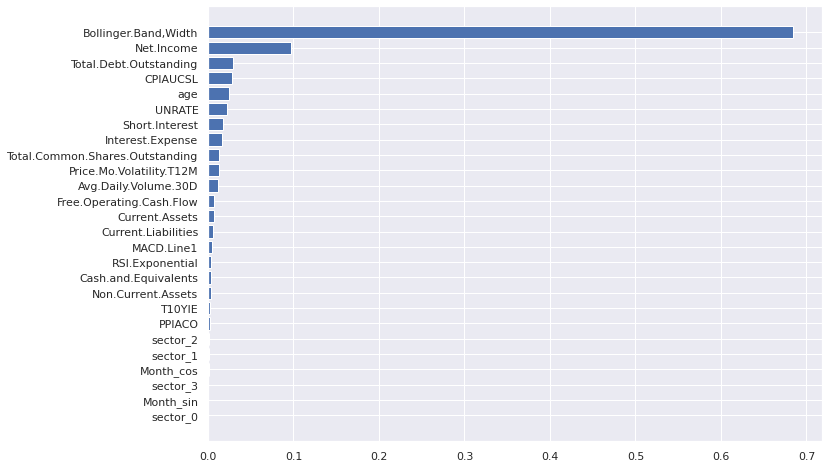

In [ ]:
f_i = list(zip(X_train_val.columns,rf.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

In [ ]:
def drop_k_features(sorted_f,k):
  return [i[0] for i in sorted_f[:k]]


In [ ]:
to_drop = drop_k_features(f_i, 5)

NameError: ignored

In [ ]:
to_drop = ['sector_0', 'Month_sin', 'Month_cos', 'sector_3', 'T10YIE']

In [ ]:
X_train_val_dropped, X_test_val_dropped = X_train_val.drop(columns=to_drop), X_test_val.drop(columns=to_drop)

# Training

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

import xgboost

In [ ]:
b = np.argsort(permutation_importance(reg,X_train,y_train)['importances_std'])


#### Predicted using value->value

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
print('R-square Correlation')
print('lr: ', r2_score(y_test_val, predicted_lr_val))
print('svm: ', r2_score(y_test_val, predicted_svm_val))
print('rf: ', r2_score(y_test_val, predicted_rf_val))
print('nn: ', r2_score(y_test_val, predicted_nn_val))
print('xgb: ', r2_score(y_test_val, predicted_xgb_val))
print('MSE Error')
print('lr: ', mean_squared_error(y_test_val, predicted_lr_val))
print('svm: ', mean_squared_error(y_test_val, predicted_svm_val))
print('rf: ', mean_squared_error(y_test_val, predicted_rf_val))
print('nn: ', mean_squared_error(y_test_val, predicted_nn_val))
print('xgb: ', mean_squared_error(y_test_val, predicted_xgb_val))

R-square Correlation
lr:  0.7090584289193649
svm:  0.052746525989994075
rf:  0.81412954759458
nn:  0.27132972836408453
xgb:  0.8565797643286381
MSE Error
lr:  7772.215941276902
svm:  25304.938458210323
rf:  4965.345061663169
nn:  19465.704677773996
xgb:  3831.3295616242813


##### After dropping less-important features

###### LR

In [ ]:
lr = linear_model.Ridge()
lr_params = {'alpha': [64, 128, 256, 512, 600, 650, 900]}
ridge_gridsearch = GridSearchCV(lr, lr_params, scoring = 'neg_mean_squared_error')
ridge_gridsearch.fit(X_train_val_dropped, y_train_val)

ridge_gridsearch.best_params_

{'alpha': 600}

In [ ]:
lr = linear_model.Lasso()
lr_params = {'alpha': [0.02, 0.04, 0.16, 0.32, 0.64]}
lasso_gridsearch = GridSearchCV(lr, lr_params, scoring = 'neg_mean_squared_error')
lasso_gridsearch.fit(X_train_val_dropped, y_train_val)

lasso_gridsearch.best_params_

{'alpha': 0.16}

In [ ]:
ridge = linear_model.Ridge(**ridge_gridsearch.best_params_)
ridge.fit(X_train_val_dropped, y_train_val)
print('Ridge: ', r2_score(y_test_val, ridge.predict(X_test_val_dropped)))

lasso = linear_model.Lasso(**lasso_gridsearch.best_params_)
lasso.fit(X_train_val_dropped, y_train_val)
print('Lasso: ', r2_score(y_test_val, lasso.predict(X_test_val_dropped)))

Ridge:  0.6908902195921647
Lasso:  0.7373515267572341


In [ ]:
predicted_lasso = lasso.predict(X_test_val_dropped)
predicted_ridge = ridge.predict(X_test_val_dropped)

###### SVR

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

gridsvm = GridSearchCV(SVR(), param_grid, scoring = 'neg_mean_squared_error')
gridsvm.fit(X_train_val_dropped, y_train_val)

print(gridsvm.best_params_)
print('svm r2: ', r2_score(y_test_val, gridsvm.best_estimator_.predict(X_test_val_dropped)))

{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
svm r2:  0.4822926005616298


In [ ]:
svm_best_params = {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
svr = SVR(**svm_best_params)
svr.fit(X_train_val_dropped, y_train_val)
predicted_svm = svr.predict(X_test_val_dropped)
print('svr: ', r2_score(y_test_val, predicted_svm))

svr:  0.4822926005616298


###### RF

In [ ]:

random_grid = {'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [130, 180, 230]}
random_rf = RandomizedSearchCV(RandomForestRegressor(), random_grid, scoring = 'neg_mean_squared_error')
random_rf.fit(X_train_val_dropped, y_train_val)

print(random_rf.best_params_)
print('rf r2: ', r2_score(y_test_val, random_rf.best_estimator_.predict(X_test_val_dropped)))

{'n_estimators': 130, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 90}
rf r2:  0.8265386326600394


In [ ]:
rf_best_params = {'n_estimators': 130, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 90}
rf = RandomForestRegressor(**rf_best_params)
rf.fit(X_train_val_dropped, y_train_val)
predicted_rf = rf.predict(X_test_val_dropped)
print('RF: ', r2_score(y_test_val, predicted_rf))

RF:  0.820169276806173


In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train_val_dropped, y_train_val)
predicted_rf = rf.predict(X_test_val_dropped)
print('RF: ', r2_score(y_test_val, predicted_rf))

RF:  0.8336875534221768


In [ ]:
xgb_params = {'max_depth': [3, 5, 6, 10, 15, 20],
              'learning_rate': [0.01, 0.1, 0.2, 0.3],
              'subsample': np.arange(0.5, 1.0, 0.1),
              'colsample_bytree': np.arange(0.4, 1.0, 0.1),
              'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
              'n_estimators': [100, 500, 1000]}


xgbr = xgboost.XGBRegressor()
randomsearch_xgbr = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=xgb_params,
                         scoring='neg_mean_squared_error',
                         n_iter=25,
                         verbose=1)
randomsearch_xgbr.fit(X_train_val_dropped, y_train_val)
print(randomsearch_xgbr.best_params_)
print('xgb r2: ', r2_score(y_test_val, randomsearch_xgbr.best_estimator_.predict(X_test_val_dropped)))

In [ ]:
xgb = xgboost.XGBRegressor()
xgb.fit(X_train_val_dropped, y_train_val)
predicted_xgb = xgb.predict(X_test_val_dropped)
print('xgb: ', r2_score(y_test_val, predicted_xgb))

[14:47:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xgb:  0.8584827063750196


### NN

In [ ]:
!pip install pytorch_lightning

In [ ]:
from torch import nn
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.optim import SGD

class model(pl.LightningModule):
    def __init__(self):
        super(model,self).__init__()
        self.fc1 = nn.Linear(28*28,256)
        self.fc2 = nn.Linear(256,128)
        self.out = nn.Linear(128,10)
        self.lr = 0.01
        self.loss = nn.CrossEntropyLoss()
    
    def forward(self,x):
        batch_size, _, _, _ = x.size()
        x = x.view(batch_size,-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)
    
    def configure_optimizers(self):
        return SGD(self.parameters(),lr = self.lr)
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.loss(logits,y)
        return loss
    
    def validation_step(self, valid_batch, batch_idx):
        x, y = valid_batch
        logits = self.forward(x)
        loss = self.loss(logits,y)

### Neural Net

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [ ]:
val_size = 0.2
train_val_split_point = int(np.ceil(len(X_train) * val_size))

X_train, y_train, X_val, y_val = X_train[train_val_split_point:], y_train[train_val_split_point:], X_train[:train_val_split_point], y_train[:train_val_split_point]

In [ ]:
class BasicDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.y)

  def __getitem__(self, index):
    return self.X[index], self.y[index]

In [ ]:
train_dataloader = DataLoader(BasicDataset(X_train, y_train), batch_size=64, shuffle=True)
val_dataloader = DataLoader(BasicDataset(X_val, y_val), batch_size=64, shuffle=True)
test_dataloader = DataLoader(BasicDataset(X_test, y_test), batch_size=64, shuffle=True)

In [ ]:
from torch.nn.modules.activation import LeakyReLU
class BasicNet(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.layers = nn.Sequential(
          nn.Linear(n_features, n_features*2),
          #nn.Dropout(p=0.5),
          nn.ReLU(),
          # nn.Linear(64, 32),
          nn.Dropout(p=0.5),
          # nn.ReLU(),
          nn.Linear(n_features*2, n_features),
          nn.ReLU(),
          # nn.LeakyReLU(),
          nn.Linear(n_features, 1)
          # nn.LeakyReLU()
        )


    def forward(self, x):

      return self.layers(x)

In [ ]:
epochs = 100
n_features = X_train.shape[1]
basenet = BasicNet(n_features)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(basenet.parameters(), lr=0.001)
device = "cpu"  # "cuda:0" if torch.cuda.is_available() else "cpu"
patience = 20


In [ ]:
training_loss_list = []
val_loss_list = []
best_val_loss = np.inf
patience_count = 0

for epoch in range(epochs):
    basenet.train()

    training_loss_per_pass = 0
    for i, (data, labels) in enumerate(train_dataloader):
        data = data.float().to(device)
        labels = labels.float().to(device)
        outputs = basenet(data)
        print(outputs.squeeze().shape, labels.shape)
        loss = criterion(outputs.squeeze(), labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss_per_pass += loss.item()
        break
    training_loss_list.append(training_loss_per_pass)
    # validation
    val_loss_per_pass = 0
    basenet.eval()
    with torch.no_grad():
        for data, labels in val_dataloader:
            data = data.float().to(device)
            labels = labels.float().to(device)
            outputs = basenet(data)
            val_loss = criterion(outputs, labels)
            val_loss_per_pass += val_loss.item()
    val_loss_list.append(val_loss_per_pass)
    print('Epoch [{}/{}], Training Loss: {:.4f}, Validation Loss: {:.4f}'
          .format(epoch + 1, epochs, training_loss_per_pass, val_loss_per_pass))
    if val_loss_per_pass <= best_val_loss:
        best_val_loss = val_loss_per_pass
        best_model = basenet.state_dict()
        patience_count = 0
        best_epoch = epoch+1
    # else:
    #     patience_count += 1
    #     if patience_count >= patience:
    #         print(" --- Early Stopped ---")
    #         break
    break

torch.Size([64]) torch.Size([64])
Epoch [1/100], Training Loss: 0.0237, Validation Loss: 1.5611


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
s = torch.tensor([[1,2,3]])
s.shape

torch.Size([1, 3])

In [ ]:
f = torch.zeros(3,1)
f

tensor([[0.],
        [0.],
        [0.]])

In [ ]:
f.squeeze()

tensor([0., 0., 0.])

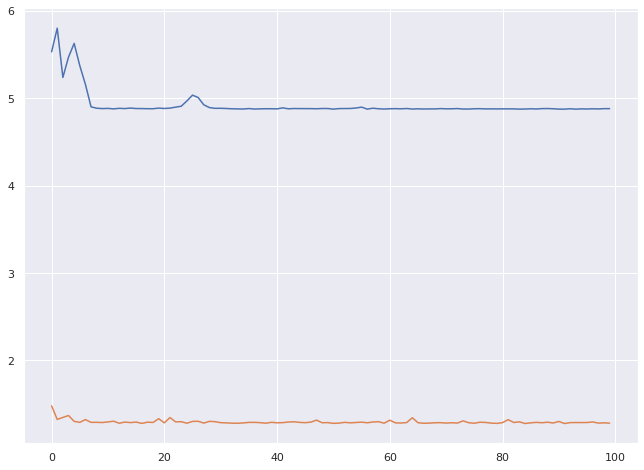

In [ ]:
plt.plot(training_loss_list)
plt.plot(val_loss_list)
plt.show()

In [ ]:
test_model = BasicNet(n_features)
test_model.load_state_dict(best_model)

with torch.no_grad():
  predicted = test_model(torch.tensor(X_test).float())

In [ ]:
predicted_nn = np.array(predicted).reshape([5591])

In [ ]:
X_test.shape

(5591, 26)

In [ ]:
print('nn: ', mean_squared_error(y_test, predicted_nn))

nn:  0.02568518415275452


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

In [ ]:
np.array(predicted).reshape([5591])

array([0.02348677, 0.02432479, 0.02410356, ..., 0.02585591, 0.02385829,
       0.02337763], dtype=float32)

#### LSTM

In [ ]:
X_train_val.shape

(16224, 26)

In [ ]:
best_lstm = LSTMV2(n_hidden=n_hidden, n_features=n_features, seq_length=seq_length, n_layers=n_layers).double()
best_lstm.load_state_dict(torch.load('/content/drive/Shareddrives/CFA project/checkpoints/state_dict_split_date.pt'))
best_lstm.eval()
with torch.no_grad():
  test_h = best_lstm.init_hidden(X_test.shape[0])
  predicted, _ = best_lstm(X_test, test_h)
predicted_lstm = np.array(predicted.reshape(predicted.shape[0]))

print('r2 score for lstm: ', r2_score(y_test, predicted_lstm))
print('mse error for lstm: ', mean_squared_error(y_test, predicted_lstm))

# Rank-score

In [ ]:
from scipy.stats import spearmanr, rankdata

In [ ]:
with open('/content/drive/Shareddrives/CFA project/checkpoints/predicted_lstmv3_seq4layer1hidden20_val.npy', 'rb') as f:
  predicted_lstm = np.load(f)

In [ ]:
mean_squared_error(y_test_val, predicted_lstm)

36107.15404161027

In [ ]:
results = np.stack([predicted_lasso, predicted_ridge,predicted_svm,predicted_rf, predicted_xgb, list(y_test_val)], axis=1)
results

array([[ 98.8487619 ,  97.07814471, 112.19300988,  93.64826421,
         88.42470551,  81.69      ],
       [ 67.55228336,  63.65136459,  76.49181724,  57.3662    ,
         55.25198364,  54.14      ],
       [ 54.46406458,  54.42315592,  34.87505988,  16.0844688 ,
         20.70265961,   7.22      ],
       ...,
       [ 80.03586169,  68.24278165, 112.22393522, 109.35054956,
        117.42856598,  85.99      ],
       [ 65.24101512,  52.67839929,  74.34854459,  39.13700201,
         50.41279984,  52.96      ],
       [ 46.30469573,  36.12274197,  50.88129465,  25.46585   ,
         27.97898865,  18.81      ]])

In [ ]:
y_test_val

array([81.69, 54.14,  7.22, ..., 85.99, 52.96, 18.81])

In [ ]:
result_df = test_idx.copy()
result_df[['predicted_lasso', 'predicted_ridge', 'predicted_svm','predicted_rf', 'predicted_xgb', 'y_true']] = results
result_df

,Stock,DATE,predicted_lasso,predicted_ridge,predicted_svm,predicted_rf,predicted_xgb,y_true
16499,A.N,2020Q1,98.848762,97.078145,112.193010,93.648264,88.424706,81.69
17383,A.N,2020Q2,67.552283,63.651365,76.491817,57.366200,55.251984,54.14
17631,A.N,2020Q3,54.464065,54.423156,34.875060,16.084469,20.702660,7.22
16315,AAP.N,2020Q1,87.457130,87.784231,99.816231,79.419857,73.725204,46.01
17243,AAP.N,2020Q2,37.325512,32.292571,18.099240,13.382900,26.219847,3.29
...,...,...,...,...,...,...,...,...
17519,ZBH.N,2020Q2,63.423003,50.650282,73.053185,44.412157,54.871468,45.77
17594,ZBH.N,2020Q3,117.190360,103.966283,157.630027,146.272434,140.569336,208.82
16488,ZTS.N,2020Q1,80.035862,68.242782,112.223935,109.350550,117.428566,85.99
17404,ZTS.N,2020Q2,65.241015,52.678399,74.348545,39.137002,50.412800,52.96


In [ ]:
result_df.to_pickle('/content/drive/Shareddrives/CFA project/data/predicted_results.pkl')

In [ ]:
result_df = pd.read_pickle('/content/drive/Shareddrives/CFA project/data/predicted_results.pkl')
result_df 


,Stock,DATE,predicted_lasso,predicted_ridge,predicted_svm,predicted_rf,predicted_xgb,y_true
16499,A.N,2020Q1,98.848762,97.078145,112.193010,93.648264,88.424706,81.69
17383,A.N,2020Q2,67.552283,63.651365,76.491817,57.366200,55.251984,54.14
17631,A.N,2020Q3,54.464065,54.423156,34.875060,16.084469,20.702660,7.22
16315,AAP.N,2020Q1,87.457130,87.784231,99.816231,79.419857,73.725204,46.01
17243,AAP.N,2020Q2,37.325512,32.292571,18.099240,13.382900,26.219847,3.29
...,...,...,...,...,...,...,...,...
17519,ZBH.N,2020Q2,63.423003,50.650282,73.053185,44.412157,54.871468,45.77
17594,ZBH.N,2020Q3,117.190360,103.966283,157.630027,146.272434,140.569336,208.82
16488,ZTS.N,2020Q1,80.035862,68.242782,112.223935,109.350550,117.428566,85.99
17404,ZTS.N,2020Q2,65.241015,52.678399,74.348545,39.137002,50.412800,52.96


0           A.N
1           A.N
2           A.N
3         AAP.N
4         AAP.N
         ...   
2023    1592.34
2024    1710.68
2025    1949.72
2026    2758.82
2027    3148.73
Length: 16224, dtype: object

In [ ]:
result_df_grouped = result_df.groupby('Stock').mean()
#result_df_grouped['combined'] = (result_df_grouped['predicted_lr'] + result_df_grouped['predicted_xgb'] + result_df_grouped['predicted_nn']) / 3

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# call MinMaxScaler object

min_max_scaler = MinMaxScaler(feature_range=(0,1))
predicted = min_max_scaler.fit_transform(result_df_grouped)

result_df_grouped[['predicted_lasso', 'predicted_ridge', 'predicted_svm','predicted_rf', 'predicted_xgb', 'y_true']] = predicted

In [ ]:
rank_result = result_df_grouped.apply(lambda x: len(result_df_grouped) - rankdata(x))

In [ ]:
rank_result

,predicted_lasso,predicted_ridge,predicted_svm,predicted_rf,predicted_xgb,y_true
Stock,,,,,,
A.N,314.0,258.0,519.0,452.0,461.0,456.0
AAP.N,428.0,336.0,615.0,580.0,490.0,628.0
AAWW.OQ,300.0,233.0,493.0,458.0,380.0,428.0
ABBV.N,514.0,401.0,629.0,570.0,604.0,572.0
ABC.N,472.0,410.0,646.0,582.0,525.0,580.0
...,...,...,...,...,...,...
XRAY.OQ,484.0,458.0,556.0,516.0,590.0,635.0
XYL.N,122.0,127.0,314.0,88.0,86.0,88.0
YUM.N,295.0,317.0,423.0,317.0,287.0,239.0


,predicted_lr,predicted_svm,predicted_rf,predicted_xgb,predicted_nn,y_true,combined
Stock,,,,,,,
A.N,0.205839,0.348464,0.058432,0.053564,0.379994,0.035521,0.204815
AAP.N,0.188623,0.299101,0.037632,0.048833,0.357800,0.014335,0.185524
AAWW.OQ,0.213552,0.445172,0.057756,0.064072,0.349974,0.038175,0.195214
ABBV.N,0.174699,0.191489,0.038887,0.028975,0.339451,0.022379,0.164370
ABC.N,0.181658,0.234826,0.036775,0.041383,0.289083,0.021677,0.144426
...,...,...,...,...,...,...,...
XRAY.OQ,0.165371,0.198671,0.044260,0.034903,0.285125,0.013415,0.134478
XYL.N,0.244579,0.468352,0.171351,0.156131,0.396338,0.118600,0.261165
YUM.N,0.198239,0.283836,0.082456,0.085961,0.313903,0.067879,0.178154


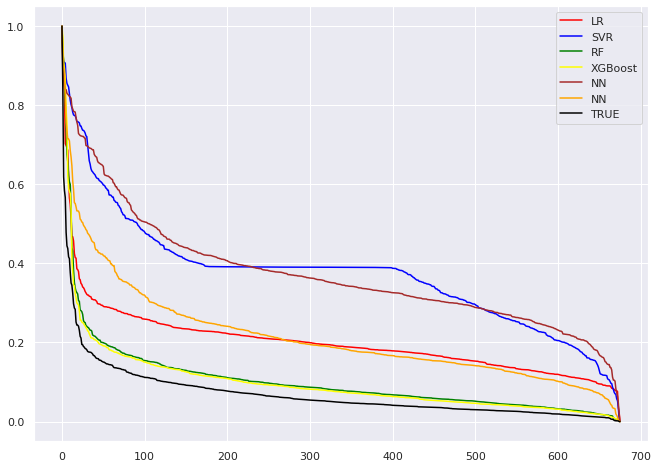

In [ ]:
# Normalize result_df_grouped

# copy the data
df_min_max_scaled = result_df_grouped.copy()
  
# apply normalization techniques
for column in df_min_max_scaled.columns:
    df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())    
      
# view normalized data
display(df_min_max_scaled)

import matplotlib.pyplot as plt
plt.plot(sorted(df_min_max_scaled['predicted_lr'], reverse=True), color='red', label='LR')
plt.plot(sorted(df_min_max_scaled['predicted_svm'], reverse=True), color='blue', label='SVR')
plt.plot(sorted(df_min_max_scaled['predicted_rf'], reverse=True), color='green', label='RF')
plt.plot(sorted(df_min_max_scaled['predicted_xgb'], reverse=True), color='yellow', label='XGBoost')
plt.plot(sorted(df_min_max_scaled['predicted_nn'], reverse=True), color='brown', label='NN')
plt.plot(sorted(df_min_max_scaled['combined'], reverse=True), color='orange', label='NN')
plt.plot(sorted(df_min_max_scaled['y_true'], reverse=True), color='black', label='TRUE')

# plt.plot(sorted((predicted[:,2]+predicted[:,3]+predicted[:,4])/3, reverse=True), color='grey', label='Combined')

plt.legend()
plt.show()

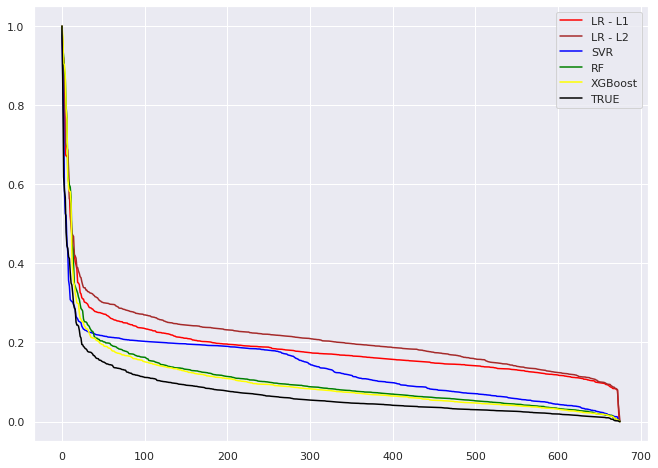

In [ ]:
import matplotlib.pyplot as plt
plt.plot(sorted(result_df_grouped['predicted_lasso'], reverse=True), color='red', label='LR - L1')
plt.plot(sorted(result_df_grouped['predicted_ridge'], reverse=True), color='brown', label='LR - L2')
plt.plot(sorted(result_df_grouped['predicted_svm'], reverse=True), color='blue', label='SVR')
plt.plot(sorted(result_df_grouped['predicted_rf'], reverse=True), color='green', label='RF')
plt.plot(sorted(result_df_grouped['predicted_xgb'], reverse=True), color='yellow', label='XGBoost')
# plt.plot(sorted(result_df_grouped['predicted_nn'], reverse=True), color='brown', label='NN')
# plt.plot(sorted(result_df_grouped['combined'], reverse=True), color='orange', label='NN')
plt.plot(sorted(result_df_grouped['y_true'], reverse=True), color='black', label='TRUE')

# plt.plot(sorted((predicted[:,2]+predicted[:,3]+predicted[:,4])/3, reverse=True), color='grey', label='Combined')

plt.legend()
plt.show()

In [ ]:
def cognitive_div(col, score_result_df):
  sorted_df = score_result_df.copy()
  for column in sorted_df:
    sorted_df[column] = sorted_df[column].sort_values(ignore_index=True)
  except_df = sorted_df.drop(columns=[col])
  len_df = len(sorted_df)
  cd_col = 0
  for score_col in except_df:
    CD = np.sqrt(sum((except_df[score_col] - sorted_df[col]) ** 2) / len_df)
    cd_col += CD
  return cd_col

In [ ]:
model_diversity = {}
for model in ['predicted_lasso', 'predicted_ridge', 'predicted_svm','predicted_rf', 'predicted_xgb']:
  model_diversity[model] = cognitive_div(model, result_df_grouped.drop(columns=['y_true']).reset_index(drop=True))

print(model_diversity)

{'predicted_lasso': 0.2578818201995152, 'predicted_ridge': 0.32921468636788725, 'predicted_svm': 0.25454084862966464, 'predicted_rf': 0.25284363915636193, 'predicted_xgb': 0.26696586468555866}


In [ ]:
lasso_spearmanr = spearmanr(rank_result['predicted_lasso'], rank_result['y_true']).correlation
ridge_spearmanr = spearmanr(rank_result['predicted_ridge'], rank_result['y_true']).correlation
svm_spearmanr = spearmanr(rank_result['predicted_svm'], rank_result['y_true']).correlation
rf_spearmanr = spearmanr(rank_result['predicted_rf'], rank_result['y_true']).correlation
xgb_spearmanr = spearmanr(rank_result['predicted_xgb'], rank_result['y_true']).correlation

In [ ]:
print('Lasso', spearmanr(len(result_df_grouped) - rankdata(result_df_grouped['predicted_lasso']), len(result_df_grouped) - result_df_grouped['y_true']))
print('Ridge', spearmanr(len(result_df_grouped) - rankdata(result_df_grouped['predicted_ridge']), len(result_df_grouped) - result_df_grouped['y_true']))
print('SVM', spearmanr(len(result_df_grouped) - rankdata(result_df_grouped['predicted_svm']), len(result_df_grouped) - result_df_grouped['y_true']))
print('RF', spearmanr(len(result_df_grouped) - rankdata(result_df_grouped['predicted_rf']), len(result_df_grouped) - result_df_grouped['y_true']))
print('XGB', spearmanr(len(result_df_grouped) - rankdata(result_df_grouped['predicted_xgb']), len(result_df_grouped) - result_df_grouped['y_true']))

Lasso SpearmanrResult(correlation=0.7846046937014619, pvalue=4.599107861361831e-142)
Ridge SpearmanrResult(correlation=0.6143220948793545, pvalue=2.2306820098976045e-71)
SVM SpearmanrResult(correlation=0.6213559112399202, pvalue=1.9320042538043102e-73)
RF SpearmanrResult(correlation=0.9215845682487358, pvalue=3.3835338789007576e-279)
XGB SpearmanrResult(correlation=0.9378254195211085, pvalue=6.13494427298e-312)


In [ ]:
grouped_result = result_df.groupby('Stock').mean()
grouped_result['ridge_svm_xgb'] = (grouped_result['predicted_ridge'] + grouped_result['predicted_svm'] + grouped_result['predicted_xgb']) / 3

In [ ]:
grouped_result['ridge_svm_xgb'] = min_max_scaler.fit_transform(grouped_result['ridge_svm_xgb'].to_numpy().reshape(-1, 1))

In [ ]:
print('score combination ridge_svm_xgb', spearmanr(len(grouped_result) - rankdata(grouped_result['ridge_svm_xgb']), rank_result['y_true']))

score combination ridge_svm_xgb SpearmanrResult(correlation=0.9113150083494795, pvalue=5.782532964959389e-262)


In [ ]:
rank_ridge_svm_xgb = rankdata(rankdata(result_df_grouped['predicted_ridge']) + rankdata(result_df_grouped['predicted_svm']) + rankdata(result_df_grouped['predicted_xgb']))
print('rank combination by average ridge_svm_xgb: ', spearmanr(rank_ridge_svm_xgb, rankdata(result_df_grouped['y_true'])).correlation)

rank combination by average ridge_svm_xgb:  0.9251046223610313


In [ ]:
(result_df_grouped['y_true'])

Stock
A.N        0.035521
AAP.N      0.014335
AAWW.OQ    0.038175
ABBV.N     0.022379
ABC.N      0.021677
             ...   
XRAY.OQ    0.013415
XYL.N      0.118600
YUM.N      0.067879
ZBH.N      0.071402
ZTS.N      0.039897
Name: y_true, Length: 676, dtype: float64

#### Weighted average combination by diversity strength

In [ ]:
grouped_result['ridge_svm_xgb_ds'] = grouped_result['predicted_ridge'] * model_diversity['predicted_ridge'] + grouped_result['predicted_svm'] * model_diversity['predicted_svm'] + grouped_result['predicted_xgb'] * model_diversity['predicted_xgb']
ridge_svm_xgb_ds_ranking = len(grouped_result) - rankdata(grouped_result['ridge_svm_xgb_ds'])
print('score combination ridge_svm_xgb', spearmanr(ridge_svm_xgb_ds_ranking, rank_result['y_true']).correlation)

score combination ridge_svm_xgb 0.9199245781093094


In [ ]:
ridge_svm_xgb_ds_rank_comb = rank_result['predicted_ridge'] * model_diversity['predicted_ridge'] + rank_result['predicted_svm'] * model_diversity['predicted_svm'] + rank_result['predicted_xgb'] * model_diversity['predicted_xgb']
ridge_svm_xgb_ds_rank_comb_ranking = rankdata(ridge_svm_xgb_ds_rank_comb)
print('rank combination ridge_svm_xgb', spearmanr(ridge_svm_xgb_ds_rank_comb_ranking, rank_result['y_true']).correlation)

rank combination ridge_svm_xgb 0.9178482017038941


In [ ]:
ridge_xgb_ds = grouped_result['predicted_ridge'] * model_diversity['predicted_ridge'] + grouped_result['predicted_xgb'] * model_diversity['predicted_xgb']
ridge_svm_xgb_ds_ranking = len(grouped_result) - rankdata(ridge_xgb_ds)
print('score combination ridge_xgb_ds', spearmanr(ridge_svm_xgb_ds_ranking, rank_result['y_true']).correlation)

score combination ridge_xgb_ds 0.806954718896735


In [ ]:
import itertools

model_list = ['predicted_lasso', 'predicted_ridge', 'predicted_svm','predicted_rf', 'predicted_xgb']
combinations = []
for L in range(2, len(model_list)+1):
    for subset in itertools.combinations(model_list, L):
        combinations.append(subset)

In [ ]:
for combo in combinations:
  

In [ ]:
a = (1,2,3)

In [ ]:
list(a)

[1, 2, 3]